<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [2]:
!pip install --user sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
trans_df = pd.read_csv('data/wayuu/COMP_NC.csv')
print(trans_df.shape)
print(trans_df.columns)

(81284, 2)
Index(['esp', 'wayuu'], dtype='object')


In [5]:
df_train, df_devtest = train_test_split(trans_df, test_size=2000, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=1000, random_state=42)

In [6]:
df_train.head()

,esp,wayuu
27297,todos querian a tom,aipu'ushi tom natuma napushua'alee
70911,los adultos tambien tienen que enfrentar mucho...,alatusu wamuin wapushua'a wayakana tu alatakat...
8772,"duermete, pajarito blanco.",putunkaa serruma
81045,resbalarse,asiranajawaa
61148,algunos hombres extraordinarios,tooloyuuirua anakana akuwa'ipa


In [7]:
df_dev.head()

,esp,wayuu
27871,so e contigo,a'lapujaashi taya pumaa
3804,en ese mismo momento llegaron tres hombres a l...,"wanaa ma'i sumaa tia, nantapaatakalaka so'ulu..."
24178,ella habla en voz alta,shiakat aashajaasu sunain emetuluin sunuiki
28383,te llamo luego,tounajeechi pia mapeena
64762,y por cientos de a os los siervos de dios espe...,tnm jee musia kakalia ma'in na'atapajuin na a'...


In [8]:
df_test.head()

,esp,wayuu
43311,y esa transformacion no acabaria el dia de su ...,makalaka nee'iratuinjatuin tu nakuwa'ipakat
49493,la mayoria de nosotros llevamos vidas muy ocup...,wayakana akujuliikana putchi nuchiki je'waa ku...
28659,luce sabroso,jemetusu ma'ain saa'in
26242,mantenga su posicion,ayata pia sunain tu paawainka
38006,la palabra de dios manda a los cristianos que ...,saashin tu wiwuliakat nnojoliinjana sunainpuna...


# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=42)

smpl['esp_toks'] = smpl.esp.apply(tokenizer.tokenize)
smpl['wayuu_toks'] = smpl.wayuu.apply(tokenizer.tokenize)

smpl['esp_words'] = smpl.esp.apply(word_tokenize)
smpl['wayuu_words'] = smpl.wayuu.apply(word_tokenize)

In [13]:
smpl.sample(5)[['esp', 'esp_words', 'esp_toks', 'wayuu', 'wayuu_words', 'wayuu_toks']]

,esp,esp_words,esp_toks,wayuu,wayuu_words,wayuu_toks
7270,asi lo anunciaron todos los profetas y la ley ...,"[asi, lo, anunciaron, todos, los, profetas, y,...","[▁asi, ▁lo, ▁anunci, aron, ▁todos, ▁los, ▁prof...","je sumaiwa paala, nnojoliiwa'aya niweetuin jua...","[je, sumaiwa, paala, ,, nnojoliiwa, ', aya, ni...","[▁je, ▁suma, iwa, ▁pa, ala, ,, ▁nno, jo, li, i..."
3247,"ademas, en el caso de los levitas, son seres m...","[ademas, ,, en, el, caso, de, los, levitas, ,,...","[▁ad, emas, ,, ▁en, ▁el, ▁caso, ▁de, ▁los, ▁le...",na wayuu sacerdote levikana okotchajapu'ukana ...,"[na, wayuu, sacerdote, levikana, okotchajapu, ...","[▁na, ▁way, uu, ▁sacerdote, ▁le, vikana, ▁ok, ..."
14955,me gusta trabajar,"[me, gusta, trabajar]","[▁me, ▁gusta, ▁trabajar]",tachekuin a'yatawaa,"[tachekuin, a, ', yatawaa]","[▁tach, eku, in, ▁a, ', yata, waa]"
14267,estamos atrapados,"[estamos, atrapados]","[▁estamos, ▁atra, p, ados]",ata'unushi waya,"[ata, ', unushi, waya]","[▁ata, ', un, ushi, ▁waya]"
36313,el ocultismo le impide a la gente tener una bu...,"[el, ocultismo, le, impide, a, la, gente, tene...","[▁el, ▁ocult, ismo, ▁le, ▁imp, ide, ▁a, ▁la, ▁...",mojusu nukuwa'ipa wanee wayuu no'ulu'u maleiwa...,"[mojusu, nukuwa, ', ipa, wanee, wayuu, no, ', ...","[▁moj, usu, ▁nuku, wa, ', ipa, ▁wane, e, ▁way,..."


In [14]:
stats = smpl[['esp_toks', 'wayuu_toks', 'esp_words', 'wayuu_words']].applymap(len).describe()
stats

,esp_toks,wayuu_toks,esp_words,wayuu_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,18.957900,34.136900,14.797000,18.675600
std,49.574827,106.578778,37.274578,57.883108
min,1.000000,1.000000,1.000000,1.000000
25%,5.000000,9.000000,4.000000,5.000000
50%,14.000000,22.000000,11.000000,12.000000
75%,23.000000,38.000000,18.000000,21.000000
max,1620.000000,3642.000000,1222.000000,1952.000000


In [15]:
print(stats.esp_toks['mean'] / stats.esp_words['mean'])
print(stats.wayuu_toks['mean'] / stats.wayuu_words['mean'])

1.2811988916672297
1.8278877251601018


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for Wayuu? If this is too often, we need to fix it somehow</p>

In [17]:
texts_with_unk = [text for text in tqdm(trans_df.wayuu) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/81284 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1122 > 1024). Running this sequence through the model will result in indexing errors


0


<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Adding a new language tag to the tokenizer and model</h1>

In [18]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [19]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [20]:
def fix_tokenizer(tokenizer, new_lang='wayuu_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [21]:
fix_tokenizer(tokenizer)

In [22]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'wayuu_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'wayuu_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'wayuu_Cyrl', '<mask>']
[256202, 256203, 256204]


In [23]:
added_token_id = tokenizer.convert_tokens_to_ids('wayuu_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [25]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">4. Preparing the training loop</h1>

In [26]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [27]:
model.cuda();

In [28]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [29]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [30]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [31]:
LANGS = [('esp', 'spa_Latn'), ('wayuu', 'wayuu_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(item[l1])
        yy.append(item[l2])
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(["supa'a nupulaneetain purinsipechonkai joulushaana su'u tu paa'upaa kaluirua ma'aka nnojoluin susu'utunuin yotoiwa'ayan musia shiyaa watunaiwa'aya eesu supula suwotojooin pulaneetakalu sutuma soototo musia suka suurala jo'uuchonle pulaneetakalu maimaleere ma'in tu paa'upaakaluirua eesu supula susotooin sutuma"], ['el suelo del planeta del principito estaba infestado de semillas de baobabs que si no se arrancan acabando de surgir y en cuanto se les reconoce pueden cubrir todo el planeta perforarlo con sus raices y si el planeta es muy peque o y los baobabs son muchos lo hacen estallar'], 'wayuu_Cyrl', 'spa_Latn')


In [32]:
MODEL_SAVE_PATH = 'models/nllb_wayuu_COMP_NC-v1'

<h1 id="6.-The-training-loop">5. The training loop</h1>

In [33]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 8.510722160339355
1000 4.281644197940826
2000 3.209442427396774
3000 2.9240963277816774
4000 2.7440299825668335
5000 2.589367916584015
6000 2.4571076142787933
7000 2.4010692604780197
8000 2.312447961688042
9000 2.255673537969589
10000 2.205026017308235
11000 2.194403454065323
12000 2.1423976490497587
13000 2.0763917227983475
14000 2.026782067835331
15000 2.015865304172039
16000 1.9767702170610428
17000 1.966378880262375
18000 1.9065403651595116
19000 1.876391348719597
20000 1.875569995045662
21000 1.833349858880043
22000 1.804924726486206
23000 1.8038270951509476
24000 1.7859919853806496
25000 1.722115798652172
26000 1.7340275478959084
27000 1.7176453656554223
28000 1.7043428007364274
29000 1.6811148352622987
30000 1.6881059908866882
31000 1.6401834967136384
32000 1.6184876485466957
33000 1.605956654906273
34000 1.6304998121261596
35000 1.591364377439022
36000 1.5926524152159691
37000 1.5652226779460907
38000 1.5544338909089566
39000 1.5416935942173005
40000 1.5079577245712281
41000 

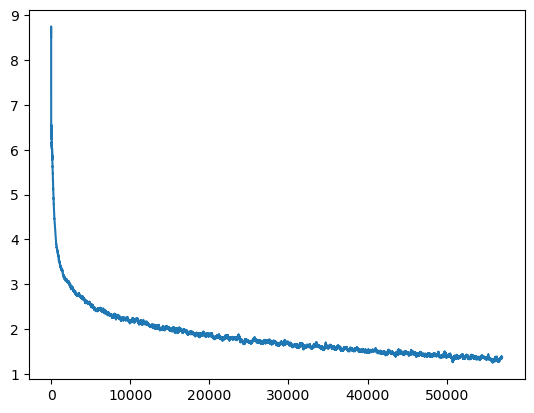

In [34]:
pd.Series(losses).ewm(100).mean().plot();

In [35]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [36]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['nnojoishi taya achuntuin']
['yo no lo pedi']
['yo no pido']


In [37]:
!ls -alsh $MODEL_SAVE_PATH

total 2.3G
4.0K drwxr-xr-x 2 jovyan users 4.0K Nov 24 19:04 .
4.0K drwxr-xr-x 5 jovyan users 4.0K Nov 24 19:04 ..
4.0K -rw-r--r-- 1 jovyan users  896 Nov 24 22:13 config.json
4.0K -rw-r--r-- 1 jovyan users  184 Nov 24 22:13 generation_config.json
2.3G -rw-r--r-- 1 jovyan users 2.3G Nov 24 22:13 pytorch_model.bin
4.7M -rw-r--r-- 1 jovyan users 4.7M Nov 24 22:13 sentencepiece.bpe.model
4.0K -rw-r--r-- 1 jovyan users 3.5K Nov 24 22:13 special_tokens_map.json
4.0K -rw-r--r-- 1 jovyan users  570 Nov 24 22:13 tokenizer_config.json


<h1 id="6.-Using-the-model">6. Testing the model</h1>

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [39]:
def fix_tokenizer(tokenizer, new_lang='wayuu_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [40]:
model_load_name = 'models/nllb_wayuu_COMP_NC-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [42]:
t = "Hola como estas, ya hiciste la tarea de hoy"
print(translate(t, 'spa_Latn', 'wayuu_Cyrl'))

["otta piakai, jamusu paa'inraka'a tu kasa paa'inrapu'ukat so'uka'i tu ka'i paainjuinjatkalu o'u maa'ulu yaa"]


In [43]:
translate(t, 'spa_Latn', 'wayuu_Cyrl', do_sample=True, num_beams=1, temperature=1.5)

["anapu'usu paa'in joolu'ukai pia kasa paa'inraka suka tu maa'insatkat so'uka'i."]

In [44]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [45]:
esp_translated = batched_translate(df_test.esp, src_lang='spa_Latn', tgt_lang='wayuu_Cyrl')

  0%|          | 0/63 [00:00<?, ?it/s]

In [46]:
df_test['esp_translated'] = [translate(t, 'wayuu_Cyrl', 'spa_Latn')[0] for t in tqdm(df_test.wayuu)]
df_test['wayuu_translated'] = [translate(t, 'spa_Latn', 'wayuu_Cyrl')[0] for t in tqdm(df_test.esp)]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [48]:
print(bleu_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(chrf_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(bleu_calc.corpus_score(df_test['wayuu_translated'].tolist(), [df_test['wayuu'].tolist()]))
print(chrf_calc.corpus_score(df_test['wayuu_translated'].tolist(), [df_test['wayuu'].tolist()]))

BLEU = 12.96 37.8/16.8/9.5/5.8 (BP = 0.948 ratio = 0.949 hyp_len = 12701 ref_len = 13383)
chrF2++ = 32.04
BLEU = 10.54 37.0/15.8/7.9/4.4 (BP = 0.883 ratio = 0.890 hyp_len = 10954 ref_len = 12311)
chrF2++ = 38.04


In [49]:
pd.options.display.max_colwidth = 100

In [50]:
df_test.sample(10, random_state=42)[['wayuu', 'esp', 'wayuu_translated', 'esp_translated']]

,wayuu,esp,wayuu_translated,esp_translated
57550,eesu waneeirua putchi eere sukujunuin nnojoluinjatuin naja'ttiruin maleiwa tu mmakat nnojoleeru ...,acudamos a ella para aclarar algunas ideas y definir bien lo que es el fin,wekirajaa sunain tia karalouktakat supula wayaawatuin saa'u tu kasa eekat supula saja'lajaain ka...,hay otras profecias que aseguran que dios no dejara que la tierra sea destruida ni que el hombre...
35457,sukujain tu wiwuliakat cho'ujaain ka'atapalain waya kasa anasu otta sukujaleein eeinjatuin waa'i...,la biblia reconoce que necesitamos tener esperanza pero tambien nos advierte sobre las esperanza...,saashin tu wiwuliakat cho'ujaasu ma'in wa'atapajuinjatuin tu kasa wa'atapajakat,la biblia nos dice que tenemos la esperanza de recibir cosas buenas y tambien nos dice que tenga...
27970,eeshii tama'ana piama tawala,tengo dos hermanos,piamashii tawalayuu,tengo dos hermanas
67034,jamushi nnojoika naashajaain maleiwa suka putchi hebreo namaa na israeliitakana,por que no,jamusu nnojotka muin sukuwa'ipa tia,por que dios no se comunico en hebreo con los israelitas
27730,ayaawajaashi taya numaa tom,me disculpe con tom,mojusu taa'in numaa tom,cuento con tom
22041,kasa ke'ireeka paa'in,que queres,kasa ke'ireeka paa'in,que quereis
63587,sulu'u tu putchi naapakat je'waa namuin na israeliitakana akujunusu su'yotoonajatuin nuta wanee ...,la ley de dios estipulaba que debia circuncidarse a los ni os cuando tenian ocho dias de vida,saashin tu putchi aapunakat numuin maleiwa o'yotoona ata nachonnii so'u mekiisat ka'i,segun la ley que jehova les habia dado a los israelitas un varon tenia que circuncidarse al ocho...
30927,atijaainapa waya aainjaa tu keesukaa,ya sabemos hacer el queso,watujaaipa aa'u a'lakajaa keesukalu,ya sabemos hacer el queso
43265,talatusu waa'in suka wakaaliinjuin wayuu supula sutujaainjatuin saa'u tu shiimuinkat tim,somos felices porque ayudamos a nuestro semejante a tener un conocimiento exacto de la verdad,talatushii ma'in waya sutuma wakaaliinjuin wayuu sunain tu shiimainkat,nos alegramos de ayudar a las personas a conocer la verdad de la biblia
12925,jaapaa ne'e jaapaainjatuka,sirvanse ustedes mismos,ji'yataa ne'e jumuin,solo den lo que tienen
